In [112]:
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.cluster as cls
import sklearn.metrics as met
import sklearn.neighbors as nb

import utils

In [113]:
data_path = "./data"

## Load road graph
# road_graph: nx.DiGraph
# with open(f"{data_path}/road_graph_nsl_sc.pickle", mode="rb") as file:
#     road_graph = pickle.load(file)
road_graph = ox.load_graphml(f"{data_path}/road_graph_ox_nsl_sc.xml")
road_graph = ox.project_graph(road_graph, to_crs=utils.EPSG_32650)

## Load camera info
cameras_dict: dict
with open(f"{data_path}/road_graph_ox_cameras.pickle", mode="rb") as file:
    cameras_dict = pickle.load(file)

Silhouette Score: 0.4954711369794857
Region records:  [1673377, 1582237, 1637736]


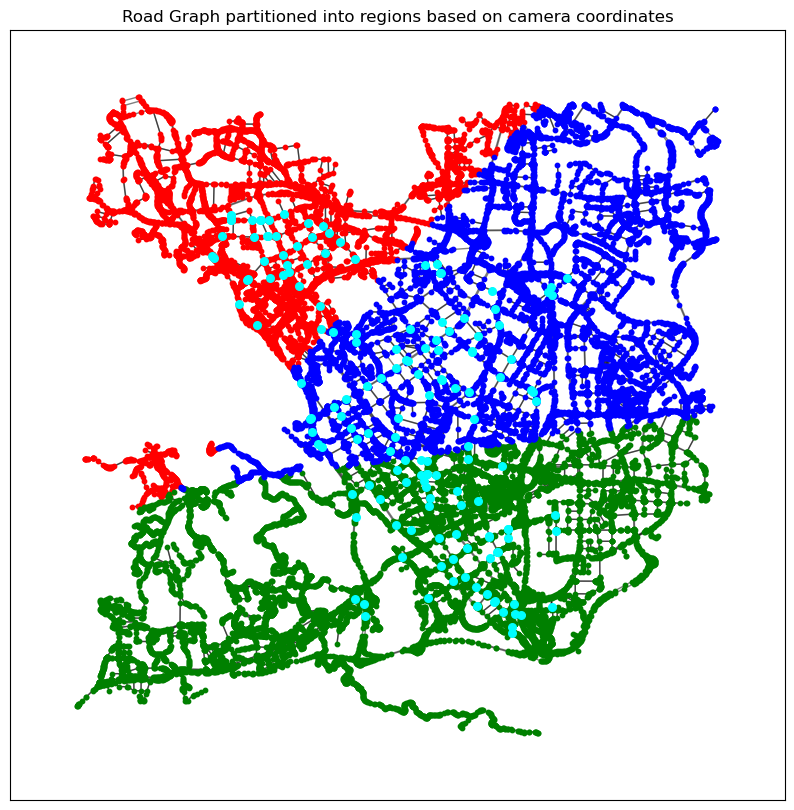

In [114]:
# Parameters
seed = 666
number_of_regions = 3
colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "cyan"]

# nodes = [{"node_id": node[0], "x": node[1]["pos"][0], "y": node[1]["pos"][1]} for node in road_graph.nodes(data=True)]
nodes = [{"node_id": node, "x": road_graph.nodes[node]["x"], "y": road_graph.nodes[node]["y"]} for node in
         road_graph.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

cameras = list(cameras_dict.values())
camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])
camera_nodes = {camera["node_id"] for camera in cameras}

# Clustering
k_means_cameras = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means_cameras.fit_predict(camera_coordinates)
print(f"Silhouette Score: {met.silhouette_score(camera_coordinates, regions, random_state=seed)}")

# Record distribution
region_records = [0 for _ in set(regions)]
for region, camera in zip(regions, cameras):
    region_records[region] += camera["records"]
print("Region records: ", region_records)

# Matching nodes to cluster centroids
kd_tree = nb.KDTree(k_means_cameras.cluster_centers_)
indices = kd_tree.query(node_coordinates, k=1, return_distance=False)
indices = indices.flatten()

region_nodes = [set() for _ in range(number_of_regions)]
for node, index in zip(nodes, indices):
    # if node["node_id"] in camera_nodes:
    #     region_nodes[index].add(node["node_id"])
    region_nodes[index].add(node["node_id"])

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# pos = nx.get_node_attributes(road_graph, "pos")
pos = {node: (road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]) for node in road_graph.nodes()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax
)

for index, node_set in enumerate(region_nodes):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=node_set,
        ax=ax
    )

nx.draw_networkx_nodes(
    road_graph,
    pos,
    node_color=colors[-1],
    node_size=30,
    nodelist=camera_nodes,
    ax=ax
)

ax.set_title("Road Graph partitioned into regions based on camera coordinates")

plt.show()

In [115]:
# def find_auxiliary_regions(G: nx.MultiDiGraph, region_nodes: list[set[int]]):
#     auxiliary_regions = list()
#     number_of_regions = len(region_nodes)
#
#     for i, j in combinations(range(number_of_regions), 2):
#         nodes_i = region_nodes[i]
#         nodes_j = region_nodes[j]
#
#         edges_i_to_j = [(u, v) for u in nodes_i for v in nodes_j if G.has_edge(u, v)]
#         edges_j_to_i = [(u, v) for u in nodes_j for v in nodes_i if G.has_edge(u, v)]
#
#         if not edges_i_to_j and not edges_j_to_i:
#             print(f"No edges for auxiliary region {i}-{j}")
#             continue
#
#         border_nodes = set()
#         for u, v in chain(edges_i_to_j, edges_j_to_i):
#             border_nodes.add(u)
#             border_nodes.add(v)
#
#         auxiliary_regions.append({
#             "auxiliary_region": (i, j),
#             "nodes": border_nodes,
#         })
#
#     return auxiliary_regions
#
#
# def expand_auxiliary_regions(G: nx.MultiDiGraph, auxiliary_regions: list[dict],
#                              buffer_size: float = 10.0) -> list[dict]:
#     results = list()
#
#     for auxiliary_region in auxiliary_regions:
#         i, j = auxiliary_region["auxiliary_region"]
#         auxiliary_region_nodes = auxiliary_region["nodes"]
#
#         # coordinates = [(G.nodes[node]["pos"][0], G.nodes[node]["pos"][1]) for node in auxiliary_region_nodes]
#         coordinates = [(G.nodes[node]["x"], G.nodes[node]["y"]) for node in auxiliary_region_nodes]
#         if len(coordinates) < 3:
#             print(f"Can't compute convex hull and alphashape for auxiliary region {i}-{j}")
#             continue
#
#         mp = MultiPoint(coordinates)
#         polygon = concave_hull(mp, ratio=0.5)
#         polygon = polygon.buffer(buffer_size)
#
#         # included_nodes = {node for node in G.nodes if Point((G.nodes[node]["pos"][0], G.nodes[node]["pos"][1])).within(polygon)}
#         included_nodes = {node for node in G.nodes if Point((G.nodes[node]["x"], G.nodes[node]["y"])).within(polygon)}
#
#         results.append({
#             "auxiliary_region": (i, j),
#             "nodes": included_nodes,
#         })
#
#     return results
#
#
# auxiliary_regions = find_auxiliary_regions(road_graph, region_nodes)
# auxiliary_regions = expand_auxiliary_regions(road_graph, auxiliary_regions, buffer_size=0.0)